# Missing Data Imputation

### Complete Case Analysis

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# For on hot encoding with sklearn
from sklearn.preprocessing import OneHotEncoder

# For on hot encoding with feature engine
from feature_engine.encoding import OneHotEncoder as fe_OneHotEncoder

In [3]:
data = pd.read_csv('datasets/houseprice/train.csv')

In [4]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [8]:
# Total Nulls
data.isna().sum().sum()

6965

In [19]:
# Columns vise nulls
null_cols = data.isna().sum()


In [24]:
# Columns with Nulls
null_cols[null_cols!=0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [25]:
# finding the variables with missing observations
# We use mean to get the % of nulls
vars_with_na = [var for var in data.columns if data[var].isnull().mean()>0]
print(len(vars_with_na))
vars_with_na

19


['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [27]:
# Finding out the % percentage of misisng values in each columns
#data_na = 
data_na = data[vars_with_na].isnull().mean()
print(data_na)
# Transform array into dataframe
data_na = pd.DataFrame(data_na.reset_index())


# Adding columns names
data_na.columns = ['variables','na_percentage']

# Order the dataframe according to na percentage
data_na.sort_values(by = 'na_percentage', ascending = False, inplace = True)

data_na

LotFrontage     0.177397
Alley           0.937671
MasVnrType      0.005479
MasVnrArea      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtFinType2    0.026027
Electrical      0.000685
FireplaceQu     0.472603
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
PoolQC          0.995205
Fence           0.807534
MiscFeature     0.963014
dtype: float64


,variables,na_percentage
16,PoolQC,0.995205
18,MiscFeature,0.963014
1,Alley,0.937671
17,Fence,0.807534
10,FireplaceQu,0.472603
0,LotFrontage,0.177397
11,GarageType,0.055479
12,GarageYrBlt,0.055479
13,GarageFinish,0.055479
14,GarageQual,0.055479


In [28]:
# We will do complete case analysis only for columns where data is missing only less than 5% of all observations
# We will remove the columns where missing data is more than 5%

In [29]:
var_cca = [var for var in data.columns if data[var].isnull().mean()<0.05 ]

In [30]:
var_cca

['Id',
 'MSSubClass',
 'MSZoning',
 'LotArea',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SaleType',
 'SaleCond

In [31]:
print(len(var_cca))
var_cca

70


['Id',
 'MSSubClass',
 'MSZoning',
 'LotArea',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SaleType',
 'SaleCond

In [32]:
# calculate % of observations  with complete cases i.e have values in all columns
# method drop na discards the observations that contain na in any row or columns
len(data[var_cca].dropna())

1412

In [35]:
data[var_cca]

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,1457,20,RL,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,1458,70,RL,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,112,0,0,0,0,4,2010,WD,Normal,142125


In [36]:
data[var_cca]

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,1457,20,RL,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,1458,70,RL,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,112,0,0,0,0,4,2010,WD,Normal,142125


In [37]:
# calculate % of observations  with complete cases i.e values in all columns
# method drop na discards the observations that contain na in any row or columns
len(data[var_cca].dropna())

1412

In [38]:
len(data)

1460

In [40]:
# Percentage of not null rows or complete cases
len(data[var_cca].dropna())/len(data)

0.9671232876712329

In [41]:
# Create a complete case dataset
# Remove observations that has na in any variable

data_cca = data[var_cca].dropna()
data.shape, data_cca.shape

((1460, 81), (1412, 70))

In [46]:
data_cca.isnull().sum().sum()

0

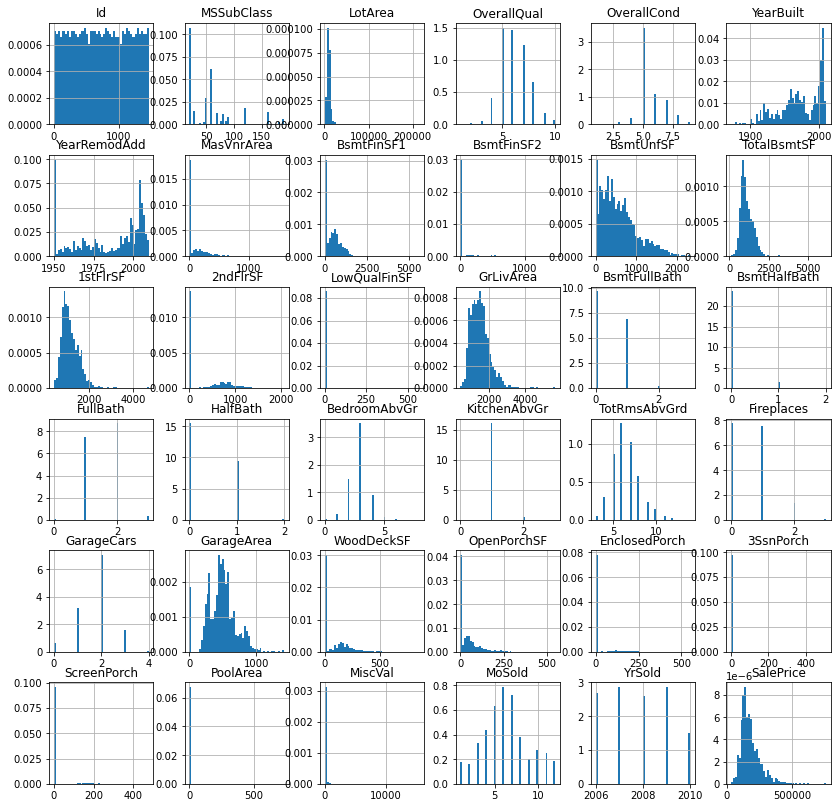

In [47]:
import matplotlib.pyplot as plt
# ploting hitogram for al the numerical variables in the complete case dataset
data_cca.hist(bins = 50, density = True,figsize =(14,14))
plt.show()

<AxesSubplot:>

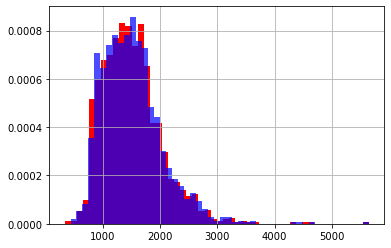

In [48]:
# Looking at the distribution of few important variables before and after drop
fig = plt.figure()
ax = fig.add_subplot(111)

# original data
data['GrLivArea'].hist(bins = 50, ax = ax, density = True, color = 'red')
data_cca['GrLivArea'].hist(bins = 50, ax = ax, density = True, color = 'blue', alpha = 0.7)

<AxesSubplot:ylabel='Density'>

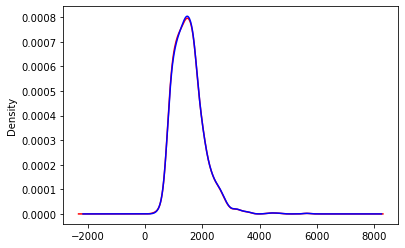

In [49]:
# density plot
# Looking at the distribution of few important variables before and after drop
fig = plt.figure()
ax = fig.add_subplot(111)

# original data
data['GrLivArea'].plot.density(color = 'red')
data_cca['GrLivArea'].plot.density(color = 'blue')
# Distribution is almost identical

<AxesSubplot:>

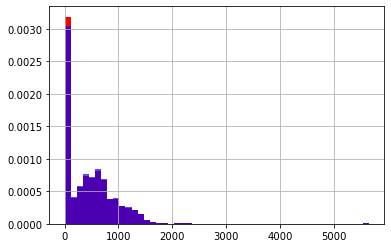

In [52]:
# Looking at the distribution of few important variables before and after drop
fig = plt.figure()
ax = fig.add_subplot(111)

# original data
data['BsmtFinSF1'].hist(bins = 50, ax = ax, density = True, color = 'red')
data_cca['BsmtFinSF1'].hist(bins = 50, ax = ax, density = True, color = 'blue', alpha = 0.7)

<AxesSubplot:ylabel='Density'>

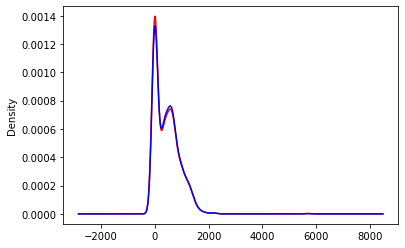

In [53]:
# density plot
# Looking at the distribution of few important variables before and after drop
fig = plt.figure()
ax = fig.add_subplot(111)

# original data
data['BsmtFinSF1'].plot.density(color = 'red')
data_cca['BsmtFinSF1'].plot.density(color = 'blue')
# Distribution is almost identical

In [59]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [63]:
data.select_dtypes(exclude = ['object']).columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [70]:
 list(data.select_dtypes('number').columns)

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

In [69]:
 list(data.select_dtypes('object').columns)

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [50]:
# Looking at teh categorical variables for CCA

In [51]:
# the following function captures the percentage of observations for each category in the original & complete case dataset
# put them together in a new dataframe


In [71]:
def categorical_distribution(df, df_cca, variable):
    tmp = pd.concat(
    [
        # percentage of observations per category, original data
        df[variable].value_counts()/len(df),
    # percentage of observations per category, cca data
        df_cca[variable].value_counts()/len(df_cca)
    ],
    axis = 1
    )
    
    # add column names
    tmp.columns = ['original', 'cca']
    return(tmp)

In [ ]:
categorical_distribution(data, data_cca, 'MasVnrType')

In [72]:
data['MasVnrType'].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [73]:
data_cca['MasVnrType'].value_counts()

None       831
BrkFace    438
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [75]:
categorical_distribution(data, data_cca, 'MasVnrType')

,original,cca
None,0.591781,0.588527
BrkFace,0.304795,0.310198
Stone,0.087671,0.090652
BrkCmn,0.010274,0.010623


In [76]:
categorical_distribution(data, data_cca, 'BsmtQual')

,original,cca
TA,0.444521,0.458924
Gd,0.423288,0.431303
Ex,0.082877,0.084986
Fa,0.023973,0.024788


In [77]:
categorical_distribution(data, data_cca, 'SaleCondition')

,original,cca
Normal,0.820548,0.820822
Partial,0.085616,0.086402
Abnorml,0.069178,0.070822
Family,0.013699,0.014164
Alloca,0.008219,0.005666
AdjLand,0.002740,0.002125


# Arbitrary Value Imputation

In [78]:
data_ti = pd.read_csv('datasets/titanic/train.csv') 

In [79]:
data_ti.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [80]:
data_ti.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [81]:
data_ti.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [82]:
# Comparing the effect of using 99 or -1 for age
# We can plot a histogram and take the values that are outside the minimum & maximum of the histogram


In [84]:
# Simple Imputer form sklearn
from sklearn.impute import SimpleImputer

# To impute different variables with different with different arbitrary values
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [85]:
# Working with house pricing dataset

In [86]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [89]:
(data.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [90]:
cols_to_use = ['OverallQual','TotalBsmtSF','1stFlrSF','GrLivArea','WoodDeckSF',
              'BsmtUnfSF','LotFrontage','MasVnrArea','GarageYrBlt','SalePrice']

In [91]:
data = pd.read_csv('datasets/houseprice/train.csv', usecols=cols_to_use)

In [92]:
data.head()

,LotFrontage,OverallQual,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,GrLivArea,GarageYrBlt,WoodDeckSF,SalePrice
0,65.0,7,196.0,150,856,856,1710,2003.0,0,208500
1,80.0,6,0.0,284,1262,1262,1262,1976.0,298,181500
2,68.0,7,162.0,434,920,920,1786,2001.0,0,223500
3,60.0,7,0.0,540,756,961,1717,1998.0,0,140000
4,84.0,8,350.0,490,1145,1145,2198,2000.0,192,250000


In [93]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LotFrontage  1201 non-null   float64
 1   OverallQual  1460 non-null   int64  
 2   MasVnrArea   1452 non-null   float64
 3   BsmtUnfSF    1460 non-null   int64  
 4   TotalBsmtSF  1460 non-null   int64  
 5   1stFlrSF     1460 non-null   int64  
 6   GrLivArea    1460 non-null   int64  
 7   GarageYrBlt  1379 non-null   float64
 8   WoodDeckSF   1460 non-null   int64  
 9   SalePrice    1460 non-null   int64  
dtypes: float64(3), int64(7)
memory usage: 114.2 KB


In [95]:
data.shape

(1460, 10)

In [98]:
# Checking the null values
data.isnull().mean()

LotFrontage    0.177397
OverallQual    0.000000
MasVnrArea     0.005479
BsmtUnfSF      0.000000
TotalBsmtSF    0.000000
1stFlrSF       0.000000
GrLivArea      0.000000
GarageYrBlt    0.055479
WoodDeckSF     0.000000
SalePrice      0.000000
dtype: float64

In [99]:
# lets seprate the data into train & test set

In [100]:
# First remove the target from the features
cols_to_use.remove('SalePrice')

In [103]:
X_train,X_test,y_train,y_test = train_test_split(data[cols_to_use],
                                                 data['SalePrice'],
                                                 test_size = 0.3,
                                                 random_state = 0)

In [104]:
X_train.shape, X_test.shape

((1022, 9), (438, 9))